In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import random
import zipfile
from google.colab import drive, files

In [3]:
# Kiểm tra GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Cố định seed
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
base_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/data'

In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

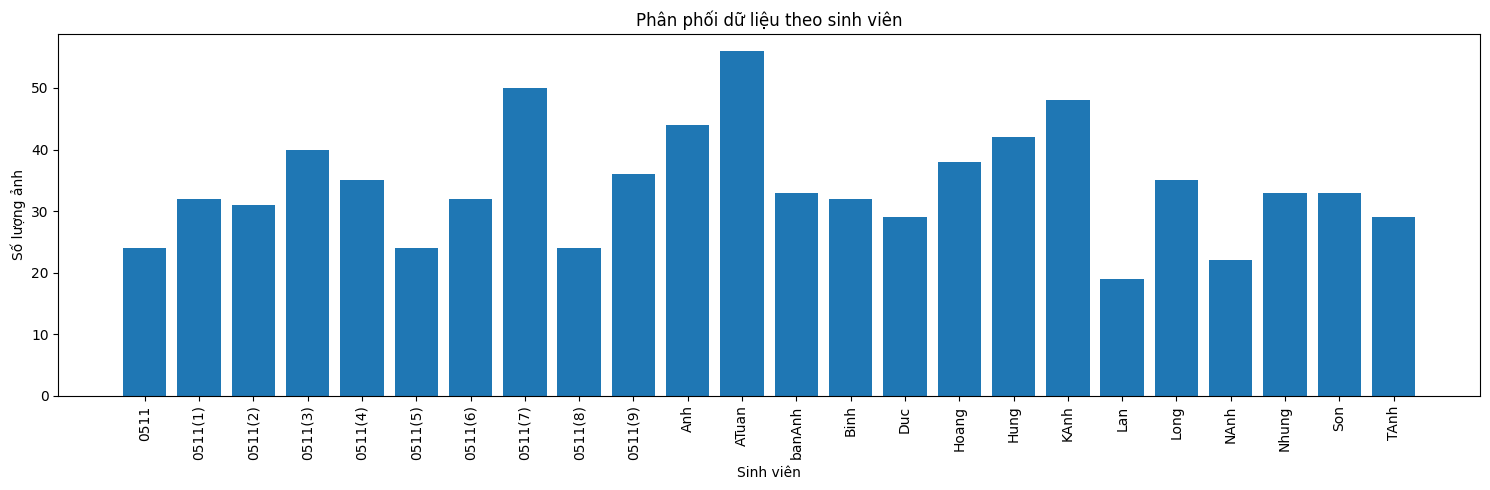

Số ảnh ít nhất: 19, nhiều nhất: 56


In [7]:
# Kiểm tra phân phối dữ liệu
student_counts = {}
for student_folder in os.listdir(train_dir):
    student_path = os.path.join(train_dir, student_folder)
    if os.path.isdir(student_path):
        images = [f for f in os.listdir(student_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        student_counts[student_folder] = len(images)

# Hiển thị phân phối
plt.figure(figsize=(15, 5))
plt.bar(student_counts.keys(), student_counts.values())
plt.xlabel('Sinh viên')
plt.ylabel('Số lượng ảnh')
plt.title('Phân phối dữ liệu theo sinh viên')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Nếu có sự mất cân bằng lớn, cân nhắc oversampling/undersampling
min_images = min(student_counts.values())
max_images = max(student_counts.values())
print(f"Số ảnh ít nhất: {min_images}, nhiều nhất: {max_images}")

In [8]:
# Kiểm tra cấu trúc dữ liệu
def check_data_structure(data_dir, type_name):
    if not os.path.exists(data_dir):
        print(f"Thư mục {type_name} không tồn tại: {data_dir}")
        return False

    class_dirs = os.listdir(data_dir)
    print(f"Thư mục {type_name} có {len(class_dirs)} lớp (sinh viên): {class_dirs}")

    total_images = 0
    class_distribution = {}

    for class_dir in class_dirs:
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(images)
            total_images += num_images
            class_distribution[class_dir] = num_images

    print(f"Tổng số ảnh trong {type_name}: {total_images}")
    print(f"Phân bố số lượng ảnh theo lớp: {class_distribution}\n")

    return True

In [9]:
train_ok = check_data_structure(train_dir, "train")
val_ok = check_data_structure(val_dir, "validation")
test_ok = check_data_structure(test_dir, "test")

Thư mục train có 24 lớp (sinh viên): ['0511', '0511(1)', '0511(2)', '0511(3)', '0511(4)', '0511(5)', '0511(6)', '0511(7)', '0511(8)', '0511(9)', 'Anh', 'ATuan', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong train: 821
Phân bố số lượng ảnh theo lớp: {'0511': 24, '0511(1)': 32, '0511(2)': 31, '0511(3)': 40, '0511(4)': 35, '0511(5)': 24, '0511(6)': 32, '0511(7)': 50, '0511(8)': 24, '0511(9)': 36, 'Anh': 44, 'ATuan': 56, 'banAnh': 33, 'Binh': 32, 'Duc': 29, 'Hoang': 38, 'Hung': 42, 'KAnh': 48, 'Lan': 19, 'Long': 35, 'NAnh': 22, 'Nhung': 33, 'Son': 33, 'TAnh': 29}

Thư mục validation có 24 lớp (sinh viên): ['0511', '0511(1)', '0511(2)', '0511(3)', '0511(4)', '0511(5)', '0511(6)', '0511(7)', '0511(8)', '0511(9)', 'Anh', 'ATuan', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong validation: 252
Phân bố số lượng ảnh theo lớp: {'0511': 6, '0511(1)': 10, '0511(2)'

In [10]:
# Cấu hình tham số
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 200

In [11]:
# Tạo danh sách các lớp (mỗi lớp là một sinh viên)
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"Số lượng lớp: {num_classes}")
print(f"Các lớp: {classes}")

Số lượng lớp: 24
Các lớp: ['0511', '0511(1)', '0511(2)', '0511(3)', '0511(4)', '0511(5)', '0511(6)', '0511(7)', '0511(8)', '0511(9)', 'ATuan', 'Anh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh', 'banAnh']


In [12]:
# Data augmentation cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    # channel_shift_range=0.1,
    # fill_mode='nearest'
)

# Chỉ rescale cho tập validation và test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 821 images belonging to 24 classes.
Found 252 images belonging to 24 classes.
Found 169 images belonging to 24 classes.


In [14]:
# Tính toán class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tính toán class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.4253472222222223), 1: np.float64(1.0690104166666667), 2: np.float64(1.103494623655914), 3: np.float64(0.8552083333333333), 4: np.float64(0.9773809523809524), 5: np.float64(1.4253472222222223), 6: np.float64(1.0690104166666667), 7: np.float64(0.6841666666666667), 8: np.float64(1.4253472222222223), 9: np.float64(0.9502314814814815), 10: np.float64(0.6108630952380952), 11: np.float64(0.7774621212121212), 12: np.float64(1.0690104166666667), 13: np.float64(1.1795977011494252), 14: np.float64(0.9002192982456141), 15: np.float64(0.814484126984127), 16: np.float64(0.7126736111111112), 17: np.float64(1.8004385964912282), 18: np.float64(0.9773809523809524), 19: np.float64(1.5549242424242424), 20: np.float64(1.0366161616161615), 21: np.float64(1.0366161616161615), 22: np.float64(1.1795977011494252), 23: np.float64(1.0366161616161615)}


In [15]:
def show_batch(image_batch, label_batch, class_indices):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(image_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i])

        # Lấy index của lớp được dự đoán (argmax)
        class_idx = np.argmax(label_batch[i])
        class_name = idx_to_class[class_idx]

        plt.title(class_name, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [16]:
images, labels = next(train_generator)

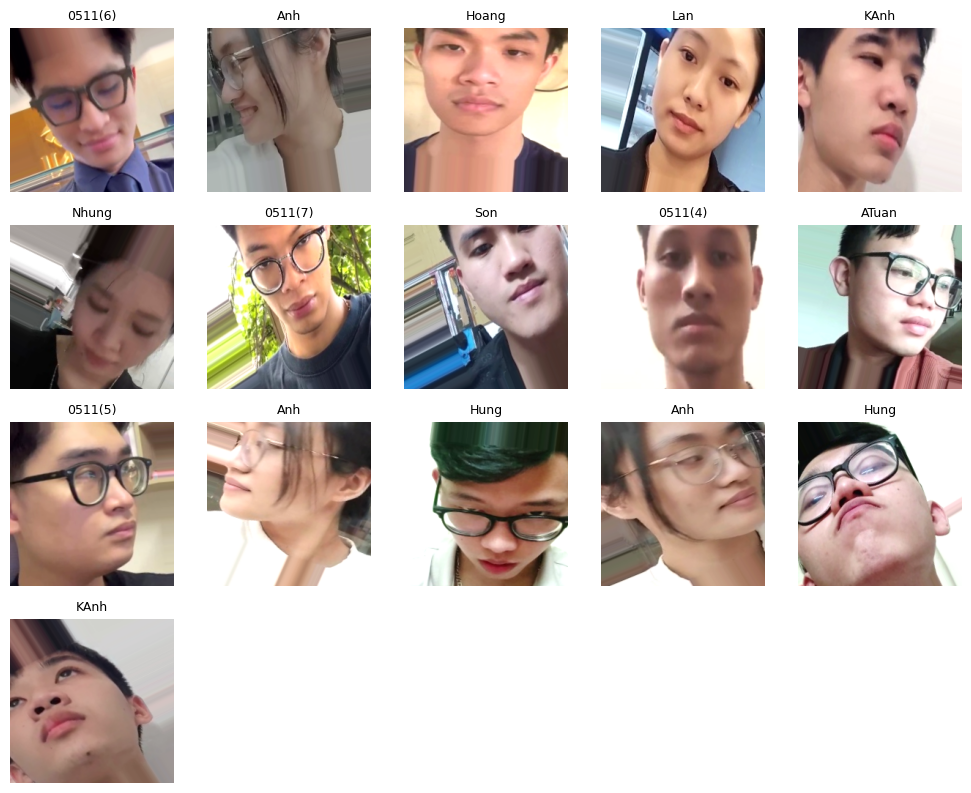

In [17]:
show_batch(images, labels, train_generator.class_indices)

In [ ]:
# def simple_lr_finder(model, train_generator, min_lr=1e-6, max_lr=1e-2, epochs=1, batch_size=32):
#     """
#     Phương pháp đơn giản để tìm learning rate phù hợp - phiên bản TF 2.x
#     """
#     # Lưu trọng số ban đầu
#     initial_weights = model.get_weights()

#     # Tính số bước trên mỗi epoch
#     steps = len(train_generator)

#     # Tính tổng số bước
#     total_steps = steps * epochs

#     # Khởi tạo danh sách để lưu learning rate và loss
#     lrs = []
#     losses = []

#     # Tính hệ số nhân cho mỗi bước
#     lr_multiplier = (max_lr / min_lr) ** (1 / total_steps)

#     # Thiết lập learning rate ban đầu
#     current_lr = min_lr

#     print("Bắt đầu tìm learning rate tối ưu...")

#     # Chạy một epoch để tìm learning rate
#     for epoch in range(epochs):
#         for batch_idx, (x_batch, y_batch) in enumerate(train_generator):
#             # Tạo optimizer mới với learning rate hiện tại
#             model.optimizer.learning_rate = current_lr

#             # Huấn luyện một batch
#             loss = model.train_on_batch(x_batch, y_batch)[0]

#             # Lưu learning rate và loss
#             lrs.append(current_lr)
#             losses.append(loss)

#             # Tăng learning rate cho batch tiếp theo
#             current_lr *= lr_multiplier

#             # In thông tin
#             if batch_idx % 10 == 0:
#                 print(f"Batch {batch_idx}/{steps}, LR: {current_lr:.6f}, Loss: {loss:.4f}")

#             # Nếu loss tăng đột biến hoặc NaN, dừng lại
#             if not np.isfinite(loss) or (len(losses) > 1 and loss > 4 * losses[0]):
#                 print("Loss tăng đột biến, dừng tìm kiếm!")
#                 break

#             # Nếu đã đủ số bước, dừng lại
#             if batch_idx + 1 >= steps:
#                 break

#     # Khôi phục trọng số ban đầu
#     model.set_weights(initial_weights)

#     # Vẽ biểu đồ
#     plt.figure(figsize=(10, 6))
#     plt.plot(lrs, losses)
#     plt.xscale('log')
#     plt.xlabel('Learning rate')
#     plt.ylabel('Loss')
#     plt.title('Learning Rate vs. Loss')
#     plt.grid(True)
#     plt.show()

#     # Tìm learning rate tại điểm loss giảm nhanh nhất
#     smooth_losses = []
#     for i in range(len(losses)):
#         if i < 5:
#             smooth_losses.append(np.mean(losses[:i+1]))
#         else:
#             smooth_losses.append(np.mean(losses[i-5:i+1]))

#     # Tính gradient
#     gradients = np.gradient(smooth_losses)

#     # Loại bỏ những điểm đầu tiên vì thường không ổn định
#     start_idx = min(10, len(gradients) // 5)

#     # Tìm điểm có gradient âm lớn nhất sau các điểm đầu tiên
#     min_gradient_idx = start_idx + np.argmin(gradients[start_idx:])

#     # Tìm learning rate tại điểm có gradient âm lớn nhất
#     if min_gradient_idx < len(lrs):
#         optimal_lr = lrs[min_gradient_idx]
#     else:
#         # Nếu có vấn đề với index, sử dụng giá trị an toàn
#         optimal_lr = min_lr * 1000  # Giá trị giữa min_lr và max_lr

#     # Learning rate an toàn
#     safe_lr = optimal_lr / 10

#     print(f"Learning rate với gradient âm lớn nhất: {optimal_lr:.6f}")
#     print(f"Learning rate an toàn (1/10): {safe_lr:.6f}")

#     return optimal_lr, safe_lr

In [18]:
def build_model(num_classes):
    # Tải MobileNetV2 pre-trained trên ImageNet, không bao gồm lớp fully connected
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Đóng băng các lớp của mô hình cơ sở
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    # Thêm các lớp mới
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Lớp output cho nhận diện khuôn mặt (số lượng lớp = số sinh viên)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Tạo model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

In [19]:
# Tạo mô hình
model, base_model = build_model(num_classes)

In [ ]:
# # Compile model với learning rate tạm thời
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
# optimal_lr, safe_lr = simple_lr_finder(
#     model,
#     train_generator,
#     min_lr=1e-7,
#     max_lr=10,
#     epochs=1,
#     batch_size=BATCH_SIZE
# )

In [20]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,111,960 (15.69 MB)

 Trainable params: 2,583,896 (9.86 MB)

 Non-trainable params: 1,528,064 (5.83 MB)

## Huấn luyện mô hình - Giai đoạn 1: Train lớp top

In [22]:
# Thư mục để lưu mô hình
model_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models'
os.makedirs(model_dir, exist_ok=True)

In [23]:
# Tạo tên mô hình với timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"face_recognition_model_{timestamp}"
model_path = os.path.join(model_dir, model_name)
os.makedirs(model_path, exist_ok=True)

In [24]:
# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage1.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=os.path.join(model_path, 'logs'),
    histogram_freq=1
)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

In [25]:
# Tính số bước trên mỗi epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

In [26]:
# Huấn luyện model - Giai đoạn 1 (chỉ train các lớp top mới thêm vào)
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2553 - loss: 3.1294
Epoch 1: val_accuracy improved from -inf to 0.19583, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 528s 10s/step - accuracy: 0.2582 - loss: 3.1150 - val_accuracy: 0.1958 - val_loss: 4.4444 - learning_rate: 0.0010
Epoch 2/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7500 - loss: 1.1457

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.19583 to 0.21667, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.7500 - loss: 1.1457 - val_accuracy: 0.2167 - val_loss: 4.8138 - learning_rate: 0.0010
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7402 - loss: 0.9492
Epoch 3: val_accuracy did not improve from 0.21667
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 352ms/step - accuracy: 0.7404 - loss: 0.9483 - val_accuracy: 0.2167 - val_loss: 6.5010 - learning_rate: 0.0010
Epoch 4/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8125 - loss: 0.7319
Epoch 4: val_accuracy did not improve from 0.21667

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8125 - loss: 0.7319 - val_accuracy: 0.2000 - val_loss: 6.3565 - learning_rate: 0.0010
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7786 - loss: 0.8020
Epoch 5: val_accuracy improved from 0.21667 to 0.26250, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/

51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 473ms/step - accuracy: 0.7794 - loss: 0.7997 - val_accuracy: 0.2625 - val_loss: 6.2509 - learning_rate: 5.0000e-04
Epoch 6/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8125 - loss: 0.3529
Epoch 6: val_accuracy improved from 0.26250 to 0.27917, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8125 - loss: 0.3529 - val_accuracy: 0.2792 - val_loss: 6.0533 - learning_rate: 5.0000e-04
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8877 - loss: 0.3715
Epoch 7: val_accuracy improved from 0.27917 to 0.35417, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.8878 - loss: 0.3706 - val_accuracy: 0.3542 - val_loss: 8.8199 - learning_rate: 5.0000e-04
Epoch 8/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8750 - loss: 0.5005
Epoch 8: val_accuracy did not improve from 0.35417
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8750 - loss: 0.5005 - val_accuracy: 0.3542 - val_loss: 8.7581 - learning_rate: 2.5000e-04
Epoch 9/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9239 - loss: 0.2463
Epoch 9: val_accuracy improved from 0.35417 to 0.37917, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 516ms/step - accuracy: 0.9238 - loss: 0.2466 - val_accuracy: 0.3792 - val_loss: 8.2511 - learning_rate: 2.5000e-04
Epoch 10/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8125 - loss: 0.4379
Epoch 10: val_accuracy improved from 0.37917 to 0.39167, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8125 - loss: 0.4379 - val_accuracy: 0.3917 - val_loss: 8.2206 - learning_rate: 2.5000e-04
Epoch 11/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9349 - loss: 0.2191
Epoch 11: val_accuracy did not improve from 0.39167
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 596ms/step - accuracy: 0.9350 - loss: 0.2185 - val_accuracy: 0.3917 - val_loss: 8.4543 - learning_rate: 1.2500e-04
Epoch 12/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.1500
Epoch 12: val_accuracy did not improve from 0.39167
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9375 - loss: 0.1500 - val_accuracy: 0.3917 - val_loss: 8.4409 - learning_rate: 1.2500e-04
Epoch 13/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9467 - loss: 0.1831
Epoch 13: val_accuracy improved from 0.39167 to 0.44167, saving model to /content/drive/Othercomputers/My Laptop/Documen


Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 450ms/step - accuracy: 0.9465 - loss: 0.1836 - val_accuracy: 0.4417 - val_loss: 7.7965 - learning_rate: 1.2500e-04
Epoch 14/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0534
Epoch 14: val_accuracy did not improve from 0.44167
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 1.0000 - loss: 0.0534 - val_accuracy: 0.4417 - val_loss: 7.7604 - learning_rate: 6.2500e-05
Epoch 15/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9462 - loss: 0.1559
Epoch 15: val_accuracy did not improve from 0.44167
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - accuracy: 0.9461 - loss: 0.1562 - val_accuracy: 0.4250 - val_loss: 7.9756 - learning_rate: 6.2500e-05
Epoch 16/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0604
Epoch 16: val_accuracy did not improve from 0.44167

Epoch 16: ReduceLROnPlateau reducing learning rate to 3.125000148429


Epoch 19: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 381ms/step - accuracy: 0.9574 - loss: 0.1736 - val_accuracy: 0.4667 - val_loss: 7.2657 - learning_rate: 3.1250e-05
Epoch 20/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0422
Epoch 20: val_accuracy did not improve from 0.46667
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 1.0000 - loss: 0.0422 - val_accuracy: 0.4667 - val_loss: 7.2479 - learning_rate: 1.5625e-05
Epoch 21/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9309 - loss: 0.2094
Epoch 21: val_accuracy improved from 0.46667 to 0.49583, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 411ms/step - accuracy: 0.9311 - loss: 0.2087 - val_accuracy: 0.4958 - val_loss: 6.2870 - learning_rate: 1.5625e-05
Epoch 22/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0194
Epoch 22: val_accuracy did not improve from 0.49583

Epoch 22: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 1.0000 - loss: 0.0194 - val_accuracy: 0.4958 - val_loss: 6.2655 - learning_rate: 1.5625e-05
Epoch 23/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9410 - loss: 0.1369
Epoch 23: val_accuracy improved from 0.49583 to 0.55000, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 521ms/step - accuracy: 0.9412 - loss: 0.1369 - val_accuracy: 0.5500 - val_loss: 5.4277 - learning_rate: 7.8125e-06
Epoch 24/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8750 - loss: 0.1761
Epoch 24: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8750 - loss: 0.1761 - val_accuracy: 0.5500 - val_loss: 5.4114 - learning_rate: 7.8125e-06
Epoch 25/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9524 - loss: 0.1518
Epoch 25: val_accuracy improved from 0.55000 to 0.59167, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5



Epoch 25: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 443ms/step - accuracy: 0.9525 - loss: 0.1518 - val_accuracy: 0.5917 - val_loss: 4.4528 - learning_rate: 7.8125e-06
Epoch 26/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8750 - loss: 0.2671
Epoch 26: val_accuracy did not improve from 0.59167
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8750 - loss: 0.2671 - val_accuracy: 0.5917 - val_loss: 4.4463 - learning_rate: 3.9063e-06
Epoch 27/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9280 - loss: 0.2638
Epoch 27: val_accuracy improved from 0.59167 to 0.62917, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - accuracy: 0.9283 - loss: 0.2623 - val_accuracy: 0.6292 - val_loss: 3.6914 - learning_rate: 3.9063e-06
Epoch 28/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0828
Epoch 28: val_accuracy did not improve from 0.62917
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 1.0000 - loss: 0.0828 - val_accuracy: 0.6292 - val_loss: 3.6813 - learning_rate: 3.9063e-06
Epoch 29/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9524 - loss: 0.1938
Epoch 29: val_accuracy improved from 0.62917 to 0.66667, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 439ms/step - accuracy: 0.9523 - loss: 0.1934 - val_accuracy: 0.6667 - val_loss: 2.9502 - learning_rate: 3.9063e-06
Epoch 30/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8750 - loss: 0.6238
Epoch 30: val_accuracy did not improve from 0.66667
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8750 - loss: 0.6238 - val_accuracy: 0.6667 - val_loss: 2.9345 - learning_rate: 3.9063e-06
Epoch 31/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9431 - loss: 0.1521
Epoch 31: val_accuracy improved from 0.66667 to 0.71667, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 461ms/step - accuracy: 0.9432 - loss: 0.1521 - val_accuracy: 0.7167 - val_loss: 2.3106 - learning_rate: 3.9063e-06
Epoch 32/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0812
Epoch 32: val_accuracy did not improve from 0.71667
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 1.0000 - loss: 0.0812 - val_accuracy: 0.7167 - val_loss: 2.2968 - learning_rate: 3.9063e-06
Epoch 33/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9649 - loss: 0.1181
Epoch 33: val_accuracy improved from 0.71667 to 0.75417, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 407ms/step - accuracy: 0.9649 - loss: 0.1184 - val_accuracy: 0.7542 - val_loss: 1.8387 - learning_rate: 3.9063e-06
Epoch 34/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8750 - loss: 0.2486
Epoch 34: val_accuracy did not improve from 0.75417
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.8750 - loss: 0.2486 - val_accuracy: 0.7542 - val_loss: 1.8339 - learning_rate: 3.9063e-06
Epoch 35/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9618 - loss: 0.1372
Epoch 35: val_accuracy improved from 0.75417 to 0.77500, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 428ms/step - accuracy: 0.9618 - loss: 0.1373 - val_accuracy: 0.7750 - val_loss: 1.4688 - learning_rate: 3.9063e-06
Epoch 36/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8125 - loss: 0.2598
Epoch 36: val_accuracy improved from 0.77500 to 0.77917, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.8125 - loss: 0.2598 - val_accuracy: 0.7792 - val_loss: 1.4643 - learning_rate: 3.9063e-06
Epoch 37/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9675 - loss: 0.1001
Epoch 37: val_accuracy improved from 0.77917 to 0.82083, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 632ms/step - accuracy: 0.9674 - loss: 0.1005 - val_accuracy: 0.8208 - val_loss: 1.1759 - learning_rate: 3.9063e-06
Epoch 38/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.1035
Epoch 38: val_accuracy did not improve from 0.82083
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9375 - loss: 0.1035 - val_accuracy: 0.8208 - val_loss: 1.1761 - learning_rate: 3.9063e-06
Epoch 39/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9665 - loss: 0.1172
Epoch 39: val_accuracy improved from 0.82083 to 0.85000, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 445ms/step - accuracy: 0.9664 - loss: 0.1175 - val_accuracy: 0.8500 - val_loss: 0.9743 - learning_rate: 3.9063e-06
Epoch 40/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0232
Epoch 40: val_accuracy did not improve from 0.85000
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 1.0000 - loss: 0.0232 - val_accuracy: 0.8500 - val_loss: 0.9723 - learning_rate: 3.9063e-06
Epoch 41/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9319 - loss: 0.2336
Epoch 41: val_accuracy improved from 0.85000 to 0.86667, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accuracy: 0.9323 - loss: 0.2324 - val_accuracy: 0.8667 - val_loss: 0.8002 - learning_rate: 3.9063e-06
Epoch 42/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0871
Epoch 42: val_accuracy did not improve from 0.86667
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 1.0000 - loss: 0.0871 - val_accuracy: 0.8667 - val_loss: 0.7982 - learning_rate: 3.9063e-06
Epoch 43/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9366 - loss: 0.1511
Epoch 43: val_accuracy improved from 0.86667 to 0.88333, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - accuracy: 0.9369 - loss: 0.1509 - val_accuracy: 0.8833 - val_loss: 0.6690 - learning_rate: 3.9063e-06
Epoch 44/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9375 - loss: 0.1440
Epoch 44: val_accuracy did not improve from 0.88333
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9375 - loss: 0.1440 - val_accuracy: 0.8833 - val_loss: 0.6678 - learning_rate: 3.9063e-06
Epoch 45/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9477 - loss: 0.1680
Epoch 45: val_accuracy improved from 0.88333 to 0.89167, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9478 - loss: 0.1679 - val_accuracy: 0.8917 - val_loss: 0.5756 - learning_rate: 3.9063e-06
Epoch 46/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.0682
Epoch 46: val_accuracy did not improve from 0.89167
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9375 - loss: 0.0682 - val_accuracy: 0.8917 - val_loss: 0.5738 - learning_rate: 3.9063e-06
Epoch 47/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9478 - loss: 0.1200
Epoch 47: val_accuracy improved from 0.89167 to 0.90833, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 392ms/step - accuracy: 0.9478 - loss: 0.1202 - val_accuracy: 0.9083 - val_loss: 0.4931 - learning_rate: 3.9063e-06
Epoch 48/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0290
Epoch 48: val_accuracy did not improve from 0.90833
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 1.0000 - loss: 0.0290 - val_accuracy: 0.9083 - val_loss: 0.4922 - learning_rate: 3.9063e-06
Epoch 49/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9413 - loss: 0.1709
Epoch 49: val_accuracy improved from 0.90833 to 0.91667, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 0.9414 - loss: 0.1712 - val_accuracy: 0.9167 - val_loss: 0.4325 - learning_rate: 3.9063e-06
Epoch 50/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0602
Epoch 50: val_accuracy did not improve from 0.91667
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 1.0000 - loss: 0.0602 - val_accuracy: 0.9167 - val_loss: 0.4309 - learning_rate: 3.9063e-06
Epoch 51/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9538 - loss: 0.1351
Epoch 51: val_accuracy improved from 0.91667 to 0.92500, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 430ms/step - accuracy: 0.9539 - loss: 0.1351 - val_accuracy: 0.9250 - val_loss: 0.3646 - learning_rate: 3.9063e-06
Epoch 52/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.0960
Epoch 52: val_accuracy did not improve from 0.92500
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9375 - loss: 0.0960 - val_accuracy: 0.9250 - val_loss: 0.3643 - learning_rate: 3.9063e-06
Epoch 53/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9544 - loss: 0.1491
Epoch 53: val_accuracy did not improve from 0.92500
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 0.9544 - loss: 0.1491 - val_accuracy: 0.9250 - val_loss: 0.3232 - learning_rate: 3.9063e-06
Epoch 54/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9375 - loss: 0.1165
Epoch 54: val_accuracy did not improve from 0.92500
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9375 - loss: 0.1165 - val_accuracy: 0.9250 - val_loss: 0.3217 - learning_rate: 3.9063e-06
Ep

51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 488ms/step - accuracy: 0.9515 - loss: 0.1437 - val_accuracy: 0.9375 - val_loss: 0.2904 - learning_rate: 3.9063e-06
Epoch 56/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9375 - loss: 0.1926
Epoch 56: val_accuracy did not improve from 0.93750
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9375 - loss: 0.1926 - val_accuracy: 0.9375 - val_loss: 0.2900 - learning_rate: 3.9063e-06
Epoch 57/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9371 - loss: 0.2042
Epoch 57: val_accuracy improved from 0.93750 to 0.94167, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 375ms/step - accuracy: 0.9372 - loss: 0.2039 - val_accuracy: 0.9417 - val_loss: 0.2551 - learning_rate: 3.9063e-06
Epoch 58/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0484
Epoch 58: val_accuracy did not improve from 0.94167
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 1.0000 - loss: 0.0484 - val_accuracy: 0.9417 - val_loss: 0.2542 - learning_rate: 3.9063e-06
Epoch 59/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9664 - loss: 0.1014
Epoch 59: val_accuracy improved from 0.94167 to 0.95000, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 374ms/step - accuracy: 0.9664 - loss: 0.1015 - val_accuracy: 0.9500 - val_loss: 0.2244 - learning_rate: 3.9063e-06
Epoch 60/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8750 - loss: 0.1320
Epoch 60: val_accuracy did not improve from 0.95000
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8750 - loss: 0.1320 - val_accuracy: 0.9500 - val_loss: 0.2244 - learning_rate: 3.9063e-06
Epoch 61/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9604 - loss: 0.1208
Epoch 61: val_accuracy improved from 0.95000 to 0.95417, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9603 - loss: 0.1212 - val_accuracy: 0.9542 - val_loss: 0.2064 - learning_rate: 3.9063e-06
Epoch 62/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9375 - loss: 0.1557
Epoch 62: val_accuracy did not improve from 0.95417
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9375 - loss: 0.1557 - val_accuracy: 0.9542 - val_loss: 0.2066 - learning_rate: 3.9063e-06
Epoch 63/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9462 - loss: 0.1835
Epoch 63: val_accuracy improved from 0.95417 to 0.96250, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 419ms/step - accuracy: 0.9463 - loss: 0.1835 - val_accuracy: 0.9625 - val_loss: 0.1895 - learning_rate: 3.9063e-06
Epoch 64/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8750 - loss: 0.2750
Epoch 64: val_accuracy did not improve from 0.96250
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8750 - loss: 0.2750 - val_accuracy: 0.9625 - val_loss: 0.1895 - learning_rate: 3.9063e-06
Epoch 65/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9644 - loss: 0.1100
Epoch 65: val_accuracy improved from 0.96250 to 0.96667, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage1.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 407ms/step - accuracy: 0.9643 - loss: 0.1101 - val_accuracy: 0.9667 - val_loss: 0.1786 - learning_rate: 3.9063e-06
Epoch 66/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9375 - loss: 0.1127
Epoch 66: val_accuracy did not improve from 0.96667
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9375 - loss: 0.1127 - val_accuracy: 0.9667 - val_loss: 0.1787 - learning_rate: 3.9063e-06
Epoch 67/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9606 - loss: 0.1524
Epoch 67: val_accuracy did not improve from 0.96667
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.9605 - loss: 0.1526 - val_accuracy: 0.9667 - val_loss: 0.1693 - learning_rate: 3.9063e-06
Epoch 68/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0483
Epoch 68: val_accuracy did not improve from 0.96667
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 1.0000 - loss: 0.0483 - val_accuracy: 0.9667 - val_loss: 0.1683 - learning_rate: 3.9063e-06
Ep

51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - accuracy: 0.9545 - loss: 0.1613 - val_accuracy: 0.9708 - val_loss: 0.1461 - learning_rate: 3.9063e-06
Epoch 74/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.0545
Epoch 74: val_accuracy did not improve from 0.97083
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9375 - loss: 0.0545 - val_accuracy: 0.9708 - val_loss: 0.1465 - learning_rate: 3.9063e-06
Epoch 75/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9631 - loss: 0.1177
Epoch 75: val_accuracy did not improve from 0.97083
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.9631 - loss: 0.1177 - val_accuracy: 0.9708 - val_loss: 0.1418 - learning_rate: 3.9063e-06
Epoch 76/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.1379
Epoch 76: val_accuracy did not improve from 0.97083
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 1.0000 - loss: 0.1379 - val_accuracy: 0.9708 - val_loss: 0.1421 - learning_rate: 3.9063e-06
Ep

51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 427ms/step - accuracy: 0.9636 - loss: 0.1217 - val_accuracy: 0.9750 - val_loss: 0.1385 - learning_rate: 3.9063e-06
Epoch 78/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0181
Epoch 78: val_accuracy did not improve from 0.97500
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.9750 - val_loss: 0.1379 - learning_rate: 3.9063e-06
Epoch 79/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9678 - loss: 0.1141
Epoch 79: val_accuracy did not improve from 0.97500
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 520ms/step - accuracy: 0.9676 - loss: 0.1145 - val_accuracy: 0.9750 - val_loss: 0.1309 - learning_rate: 3.9063e-06
Epoch 80/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0110
Epoch 80: val_accuracy did not improve from 0.97500
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.9750 - val_loss: 0.1312 - learning_rate: 3.9063e-06
Ep

51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 395ms/step - accuracy: 0.9654 - loss: 0.1206 - val_accuracy: 0.9792 - val_loss: 0.1278 - learning_rate: 3.9063e-06
Epoch 82/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9375 - loss: 0.2262
Epoch 82: val_accuracy did not improve from 0.97917
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9375 - loss: 0.2262 - val_accuracy: 0.9792 - val_loss: 0.1277 - learning_rate: 3.9063e-06
Epoch 83/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9515 - loss: 0.1211
Epoch 83: val_accuracy did not improve from 0.97917
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 482ms/step - accuracy: 0.9517 - loss: 0.1209 - val_accuracy: 0.9792 - val_loss: 0.1253 - learning_rate: 3.9063e-06
Epoch 84/200
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0268
Epoch 84: val_accuracy did not improve from 0.97917
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 1.0000 - loss: 0.0268 - val_accuracy: 0.9792 - val_loss: 0.1251 - learning_rate: 3.9063e-06
Ep

## Fine-tuning - Giai đoạn 2: Tinh chỉnh một số lớp của mô hình cơ sở

In [27]:
# Mở khóa các lớp cuối của base model
# Đóng băng các lớp đầu, mở khóa các lớp cuối để fine-tune
for layer in base_model.layers[:-30]:  # Giữ các lớp đầu đóng băng
    layer.trainable = False
for layer in base_model.layers[-30:]:  # Mở khóa 40 lớp cuối
    layer.trainable = True

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate thấp hơn cho fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
# Cập nhật callbacks cho giai đoạn 2
checkpoint_stage2 = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage2.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_stage2 = [checkpoint_stage2, early_stopping, reduce_lr, tensorboard]

In [30]:
# Huấn luyện giai đoạn 2 - Fine-tuning
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_stage2,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9119 - loss: 0.2680
Epoch 1: val_accuracy improved from -inf to 0.95417, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage2.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 581ms/step - accuracy: 0.9120 - loss: 0.2677 - val_accuracy: 0.9542 - val_loss: 0.2286 - learning_rate: 1.0000e-04
Epoch 2/100
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8750 - loss: 0.3790
Epoch 2: val_accuracy did not improve from 0.95417
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8750 - loss: 0.3790 - val_accuracy: 0.9542 - val_loss: 0.2282 - learning_rate: 1.0000e-04
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9513 - loss: 0.2084
Epoch 3: val_accuracy improved from 0.95417 to 0.98333, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250528-030418/best_model_stage2.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.9513 - loss: 0.2081 - val_accuracy: 0.9833 - val_loss: 0.0849 - learning_rate: 1.0000e-04
Epoch 4/100
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0113
Epoch 4: val_accuracy did not improve from 0.98333
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.9833 - val_loss: 0.0840 - learning_rate: 1.0000e-04
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9678 - loss: 0.1042
Epoch 5: val_accuracy did not improve from 0.98333
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - accuracy: 0.9676 - loss: 0.1045 - val_accuracy: 0.9833 - val_loss: 0.0567 - learning_rate: 1.0000e-04
Epoch 6/100
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 6: val_accuracy did not improve from 0.98333
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9833 - val_loss: 0.0580 - learning_rate: 1.0000e-04
Epoch 7/

51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 487ms/step - accuracy: 0.9472 - loss: 0.1271 - val_accuracy: 0.9917 - val_loss: 0.0464 - learning_rate: 1.0000e-04
Epoch 8/100
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 1.0000 - loss: 0.0790
Epoch 8: val_accuracy did not improve from 0.99167
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 1.0000 - loss: 0.0790 - val_accuracy: 0.9917 - val_loss: 0.0467 - learning_rate: 1.0000e-04
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9308 - loss: 0.2141
Epoch 9: val_accuracy did not improve from 0.99167
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.9312 - loss: 0.2130 - val_accuracy: 0.9792 - val_loss: 0.0917 - learning_rate: 1.0000e-04
Epoch 10/100
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.0000 - loss: 0.0513
Epoch 10: val_accuracy did not improve from 0.99167

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 1.0000 - loss: 0.05

## 8. Đánh giá mô hình trên tập test

In [31]:
# Tải model tốt nhất
best_model_path = os.path.join(model_path, 'best_model_stage2.h5')
model = load_model(best_model_path)

In [32]:
# Đánh giá trên tập test
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 102s 11s/step - accuracy: 0.9828 - loss: 0.1079
Test accuracy: 0.9937
Test loss: 0.0440


In [33]:
# Dự đoán trên tập test
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thực tế
test_labels = test_generator.classes[:len(y_pred_classes)]

# In báo cáo phân loại
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 461ms/step
Classification Report:

              precision    recall  f1-score   support

        0511       1.00      0.83      0.91         6
     0511(1)       1.00      1.00      1.00         7
     0511(2)       1.00      1.00      1.00         7
     0511(3)       1.00      1.00      1.00         7
     0511(4)       1.00      1.00      1.00         8
     0511(5)       1.00      1.00      1.00         6
     0511(6)       1.00      1.00      1.00         7
     0511(7)       1.00      1.00      1.00        10
     0511(8)       1.00      1.00      1.00         5
     0511(9)       1.00      1.00      1.00         7
       ATuan       1.00      1.00      1.00        10
         Anh       1.00      1.00      1.00         9
        Binh       1.00      1.00      1.00         7
         Duc       1.00      1.00      1.00         7
       Hoang       1.00      1.00      1.00         7
        Hung       1.00      1.00      1.00         8
        KAnh    

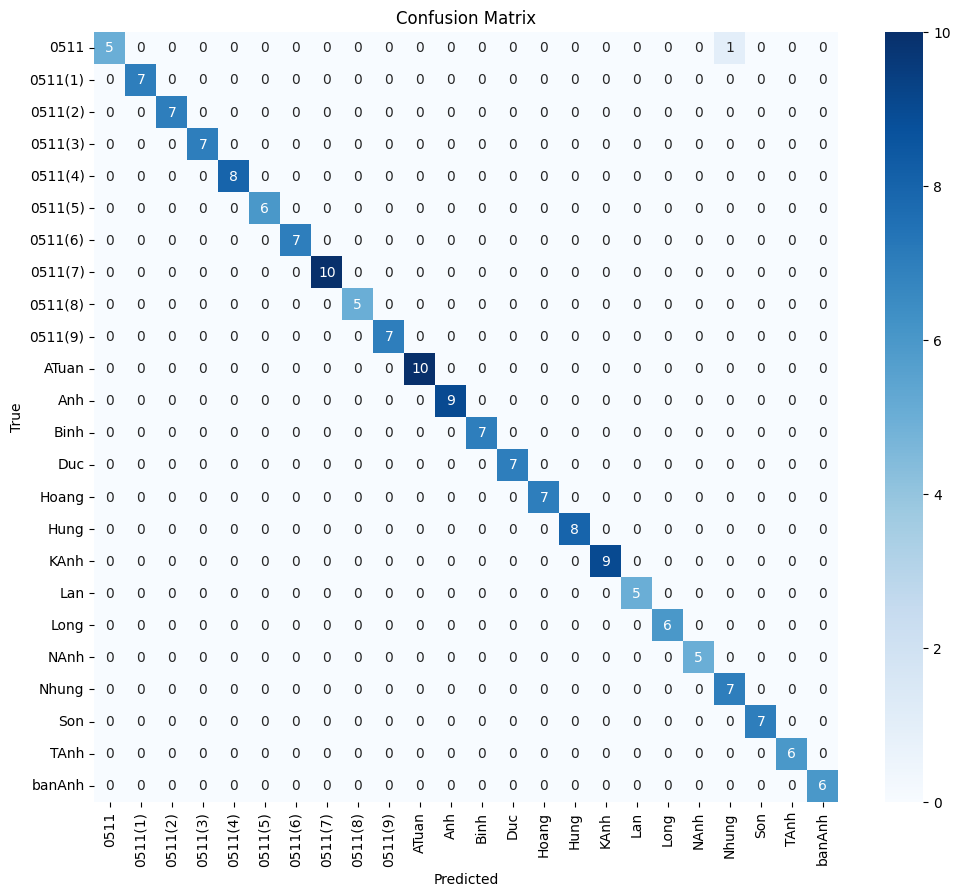

In [34]:
# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Hiển thị các kết quả dự đoán

In [35]:
def show_prediction_examples(test_generator, model, class_indices, num_examples=10):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Lấy các batch cho đến khi đủ số lượng ví dụ
    examples = []
    count = 0

    for i in range(min(50, len(test_generator))):
        if count >= num_examples:
            break

        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            if count >= num_examples:
                break

            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])
            confidence = y_pred_batch[j][pred_class_idx]

            is_correct = true_class_idx == pred_class_idx

            examples.append({
                'image': x_batch[j],
                'true_class': idx_to_class[true_class_idx],
                'pred_class': idx_to_class[pred_class_idx],
                'confidence': confidence,
                'is_correct': is_correct
            })

            count += 1

    # Hiển thị các ví dụ
    plt.figure(figsize=(15, 4 * num_examples//5 + 4))

    for i, example in enumerate(examples):
        ax = plt.subplot(num_examples//5 + 1, 5, i + 1)

        plt.imshow(example['image'])

        title_color = 'green' if example['is_correct'] else 'red'
        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color=title_color,
            fontsize=9
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [36]:
show_prediction_examples(test_generator, model, test_generator.class_indices, num_examples=50)

Output hidden; open in https://colab.research.google.com to view.

Hiển thị các dự đoán sai trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Tìm thấy 1 dự đoán sai. Hiển thị tối đa 1 ví dụ:


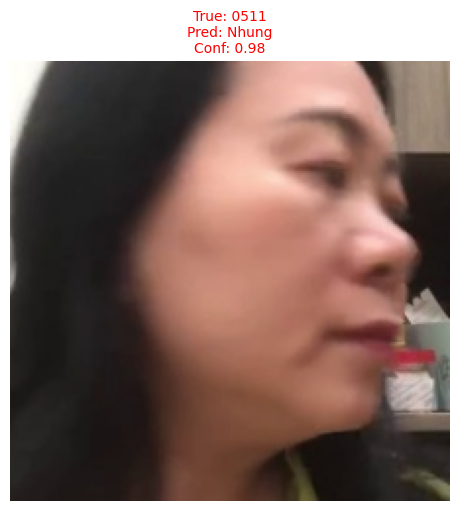

In [37]:
def show_incorrect_predictions(test_generator, model, class_indices, num_examples=15):
    """
    Hiển thị các ví dụ dự đoán sai từ tập test

    Args:
        test_generator: Generator cho tập test
        model: Mô hình đã huấn luyện
        class_indices: Dictionary ánh xạ tên lớp thành index
        num_examples: Số lượng ví dụ sai muốn hiển thị
    """
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Danh sách lưu các dự đoán sai
    incorrect_examples = []

    # Duyệt qua tập test để tìm các dự đoán sai
    for i in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])

            # Kiểm tra nếu dự đoán sai
            if true_class_idx != pred_class_idx:
                confidence = y_pred_batch[j][pred_class_idx]

                incorrect_examples.append({
                    'image': x_batch[j],
                    'true_class': idx_to_class[true_class_idx],
                    'pred_class': idx_to_class[pred_class_idx],
                    'confidence': confidence
                })

                # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
                if len(incorrect_examples) >= num_examples:
                    break

        # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
        if len(incorrect_examples) >= num_examples:
            break

    if not incorrect_examples:
        print("Không có dự đoán sai nào được tìm thấy trong tập test!")
        return

    total_found = len(incorrect_examples)
    print(f"Tìm thấy {total_found} dự đoán sai. Hiển thị tối đa {min(num_examples, total_found)} ví dụ:")

    # Hiển thị các ví dụ sai
    rows = (min(num_examples, total_found) // 3) + (1 if min(num_examples, total_found) % 3 > 0 else 0)
    plt.figure(figsize=(15, 5 * rows))

    for i, example in enumerate(incorrect_examples[:num_examples]):
        ax = plt.subplot(rows, 3, i + 1)

        plt.imshow(example['image'])

        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color='red',
            fontsize=10
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Thực thi hàm để hiển thị các dự đoán sai
print("Hiển thị các dự đoán sai trên tập test:")
show_incorrect_predictions(test_generator, model, test_generator.class_indices, num_examples=15)

## Vẽ đồ thị quá trình huấn luyện

In [38]:
def plot_training_history(history1, history2=None, title="Training History"):
    plt.figure(figsize=(15, 5))

    # Đồ thị accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Stage 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Stage 1 Validation')


    # Tiếp tục từ đoạn code trước
    if history2:
        # Xác định điểm bắt đầu của stage 2
        stage1_epochs = len(history1.history['accuracy'])
        x_stage2 = range(stage1_epochs, stage1_epochs + len(history2.history['accuracy']))

        plt.plot(x_stage2, history2.history['accuracy'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_accuracy'], label='Stage 2 Validation')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Đồ thị loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Stage 1 Train')
    plt.plot(history1.history['val_loss'], label='Stage 1 Validation')

    if history2:
        plt.plot(x_stage2, history2.history['loss'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_loss'], label='Stage 2 Validation')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

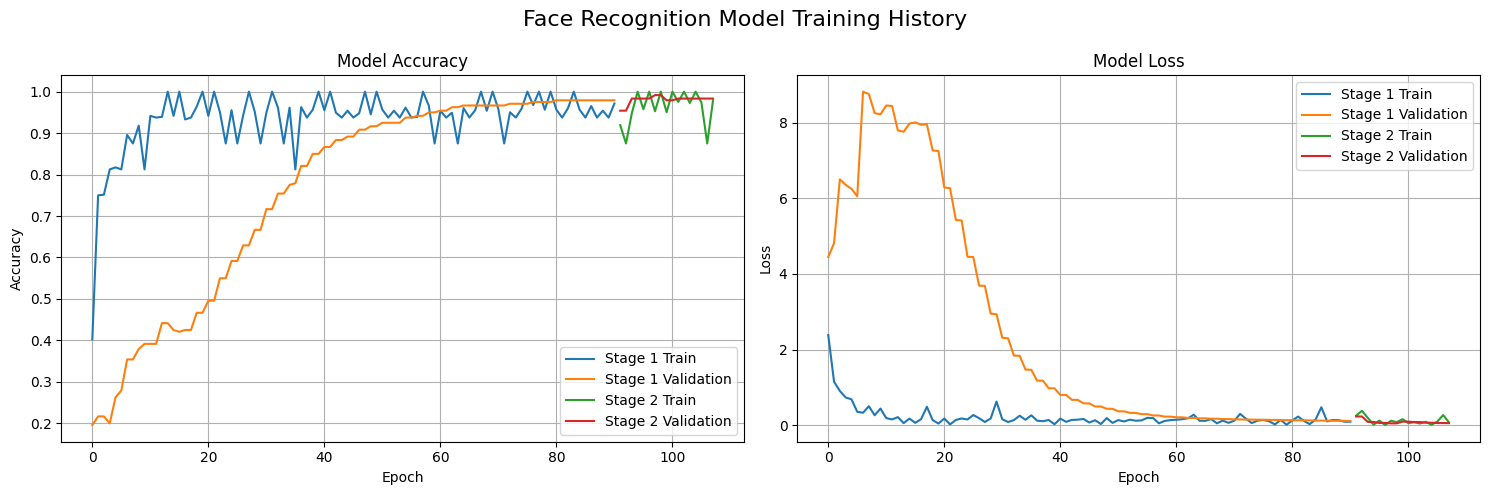

In [39]:
plot_training_history(history_stage1, history_stage2, "Face Recognition Model Training History")

In [40]:
import pickle
with open(os.path.join(model_path, 'history.pkl'), 'wb') as f:
    pickle.dump({
        'stage1': history_stage1.history,
        'stage2': history_stage2.history
    }, f)

In [41]:
import tensorflow as tf

# Bước 1: Load mô hình .h5
model = tf.keras.models.load_model(best_model_path)

# Bước 2: Chuyển sang định dạng TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Bước 3: Lưu lại file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Chuyển đổi thành công!")

Saved artifact at '/tmp/tmpsq9c6aha'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  135997017914064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017912720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017899088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017912336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017913680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017900048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017902928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017900816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017900624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135997017915024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13599701790196

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# def visualize_feature_maps(model, img_path, layer_name=None, num_filters=64, size=8):
#     """
#     Trực quan hóa feature maps từ một lớp cụ thể của mô hình khi đầu vào là một ảnh

#     Args:
#         model: Mô hình đã huấn luyện
#         img_path: Đường dẫn đến ảnh đầu vào
#         layer_name: Tên của lớp cần trực quan hóa (nếu None, sẽ hiển thị danh sách các lớp)
#         num_filters: Số lượng filters tối đa để hiển thị
#         size: Kích thước hình vuông để hiển thị feature maps (ví dụ: 8x8=64 feature maps)
#     """
#         # Hiển thị danh sách các lớp nếu không chỉ định layer_name
#     if layer_name is None:
#         for i, layer in enumerate(model.layers):
#             # Lấy thông tin shape một cách an toàn
#             try:
#                 if hasattr(layer, 'output_shape'):
#                     shape_info = str(layer.output_shape)
#                 elif hasattr(layer, 'output'):
#                     shape_info = str(layer.output.shape)
#                 else:
#                     shape_info = "Shape không khả dụng"
#             except:
#                 shape_info = "Không thể xác định shape"

#             print(f"{i}: {layer.name}, Type: {layer.__class__.__name__}, Shape: {shape_info}")
#         return

#     # Tạo mô hình mới lấy đầu ra từ lớp được chỉ định
#     layer_output = model.get_layer(layer_name).output
#     activation_model = Model(inputs=model.input, outputs=layer_output)

#     # Tải và xử lý ảnh đầu vào
#     img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
#     img_tensor = img_to_array(img)
#     img_tensor = img_tensor / 255.0  # Chuẩn hóa
#     img_tensor = np.expand_dims(img_tensor, axis=0)  # Thêm batch dimension

#     # Lấy activations
#     activations = activation_model.predict(img_tensor)

#     # Tính toán số cột, số hàng để hiển thị
#     n_features = activations.shape[-1]
#     n_features = min(n_features, num_filters)  # Giới hạn số lượng filters hiển thị

#     # Tính số hàng và cột cần thiết
#     size = min(size, int(np.ceil(np.sqrt(n_features))))
#     cols = size
#     rows = int(np.ceil(n_features / cols))

#     # Hiển thị ảnh gốc
#     plt.figure(figsize=(12, 12))
#     plt.subplot(rows + 1, cols, 1)
#     plt.imshow(img)
#     plt.title('Original Image')
#     plt.axis('off')

#     # Hiển thị feature maps
#     for i in range(n_features):
#         plt.subplot(rows + 1, cols, i + cols + 1)
#         feature_map = activations[0, :, :, i]

#         # Chuẩn hóa feature map để hiển thị
#         feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-7)

#         plt.imshow(feature_map, cmap='viridis')
#         plt.title(f'Filter {i}')
#         plt.axis('off')

#     plt.suptitle(f'Feature Maps from {layer_name}')
#     plt.tight_layout()
#     plt.show()

# # Hàm trực quan hóa nhiều lớp cùng một lúc
# def visualize_multiple_layers(model, img_path, layer_names=None, filters_per_layer=16):
#     """
#     Trực quan hóa feature maps từ nhiều lớp của mô hình

#     Args:
#         model: Mô hình đã huấn luyện
#         img_path: Đường dẫn đến ảnh đầu vào
#         layer_names: Danh sách tên các lớp cần trực quan hóa
#         filters_per_layer: Số filters hiển thị cho mỗi lớp
#     """
#     # Nếu không có danh sách lớp, chọn một số lớp đại diện
#     if layer_names is None:
#         # Tự động chọn các lớp conv đại diện từ đầu, giữa và cuối mạng
#         conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name.lower()]
#         layer_names = []
#         if len(conv_layers) >= 3:
#             # Lấy layer ở đầu, giữa và cuối
#             layer_names = [
#                 conv_layers[0],
#                 conv_layers[len(conv_layers) // 2],
#                 conv_layers[-1]
#             ]
#         else:
#             layer_names = conv_layers

#     # Tải và xử lý ảnh đầu vào
#     img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
#     img_tensor = img_to_array(img)
#     img_tensor = img_tensor / 255.0
#     img_tensor = np.expand_dims(img_tensor, axis=0)

#     # Hiển thị ảnh gốc
#     plt.figure(figsize=(12, 5 * len(layer_names)))
#     plt.subplot(len(layer_names) + 1, 1, 1)
#     plt.imshow(img)
#     plt.title('Original Image')
#     plt.axis('off')

#     # Hiển thị feature maps cho từng lớp
#     for i, layer_name in enumerate(layer_names):
#         try:
#             # Tạo mô hình lấy đầu ra từ layer này
#             layer_output = model.get_layer(layer_name).output
#             activation_model = Model(inputs=model.input, outputs=layer_output)

#             # Lấy activations
#             activations = activation_model.predict(img_tensor)

#             # Xác định số hàng, cột cho subplot
#             n_features = min(filters_per_layer, activations.shape[-1])
#             cols = 8
#             rows = int(np.ceil(n_features / cols))

#             # Tạo tiêu đề cho layer
#             plt.subplot(len(layer_names) + 1, 1, i + 2)
#             plt.title(f"Feature maps from layer: {layer_name} (showing {n_features}/{activations.shape[-1]} filters)")
#             plt.axis('off')

#             # Tạo một figure mới cho layer này
#             plt.figure(figsize=(16, 2 * rows))
#             plt.suptitle(f"Feature maps from layer: {layer_name} (shape: {activations.shape[1:]}, showing {n_features}/{activations.shape[-1]} filters)")

#             # Hiển thị các feature map
#             for j in range(n_features):
#                 plt.subplot(rows, cols, j + 1)
#                 feature_map = activations[0, :, :, j]

#                 # Chuẩn hóa để hiển thị
#                 if feature_map.max() > feature_map.min():
#                     feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

#                 plt.imshow(feature_map, cmap='viridis')
#                 plt.title(f'Filter {j}')
#                 plt.axis('off')

#             plt.tight_layout()
#             plt.show()

#         except Exception as e:
#             print(f"Không thể trực quan hóa lớp {layer_name}: {e}")

# # Sử dụng:
# # 1. Hiển thị danh sách các lớp trong mô hình
# visualize_feature_maps(model, None)

# # 2. Trực quan hóa feature maps từ một lớp cụ thể
# # Thay 'path_to_test_image.jpg' bằng đường dẫn đến ảnh test
# image_path = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/data/test/ATuan/segment_00_frame_01.jpg'
# # Thay 'conv_dw_1' bằng tên lớp bạn muốn trực quan hóa (lấy từ kết quả bước 1)
# visualize_feature_maps(model, image_path, layer_name='expanded_conv_depthwise', num_filters=32)

# # 3. Trực quan hóa feature maps từ nhiều lớp
# # Bạn có thể chỉ định danh sách lớp hoặc để hàm tự động chọn
# visualize_multiple_layers(model, image_path)

# # 4. Chỉ định các lớp cụ thể để trực quan hóa
# early_layer = 'block_1_expand'  # Layer đầu
# middle_layer = 'block_10_expand'  # Layer giữa
# late_layer = 'Conv_1'  # Layer cuối
# visualize_multiple_layers(model, image_path, layer_names=[early_layer, middle_layer, late_layer])